# Simple Michelson Interferometer


In [1]:
from pykat import finesse                  # Importing the pykat.finesse package
from pykat.commands import *               # Importing all packages in pykat.commands.
from IPython.display import display, HTML  # Allows us to display HTML.
%matplotlib notebook
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)
import numpy as np                         # Importing numpy
import matplotlib                          # For plotting
import matplotlib.pyplot as plt      
# Initialises the PyKat plotting tool. Change dpi value 
# to change figure sizes on your screen.
#pykat.init_pykat_plotting(dpi=32)       

                                              ..-
    PyKat 1.2.2           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



<IPython.core.display.Javascript object>


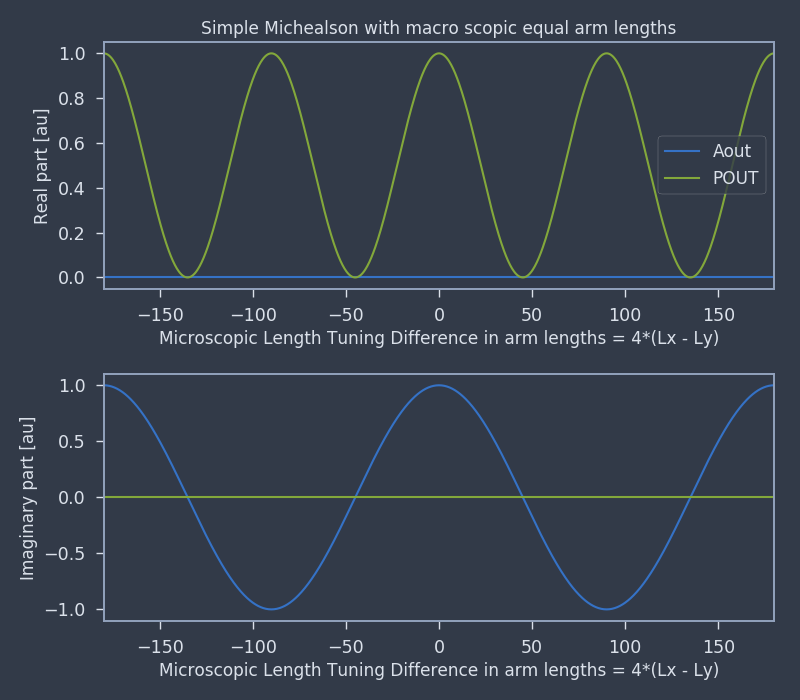

In [2]:
basekat=finesse.kat() # initialising Finesse
basekat.verbose = False
basecode = """
l laser 1 0 0 n0    # Laser (Power = 1 W, wavelength offset = 0, init phase = 0)
s s-w 1 n0 n1       # Space (Length = 1 m)
bs bs1 0.5 0.5 0 45 n1 n2 n3 n4   # Beam splitter R = 0.5, T = 0.5, 
                                  #  phi = 0, AoI = 45
s s-n 1000 n2 n5                  # Space 1000m Ly 
m1 ETMY 5e-06 3.75e-05 0 n5 dump  # Mirror_y R = 1, T = 0, phi = 0           
s s-e 1000 n3 n6                  # Space 1000m Lx
m1 ETMX 5e-06 3.75e-05 0 n6 dump               # Mirror_x R = 1, T = 0, phi = 0
"""
basekat.parse(basecode) # Parsing the FINESSE-code
detector_code = '''
pd0 POUT n4         # Power Output at Asymmetric Port 
ad Aout 0 n4        # Ampitude Detector at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -180 180 1000
yaxis re:im
put* ETMX phi $mx1
'''
kat1 = deepcopy(basekat)
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
#out1.title = "Simple Michealson with equal Arm Lengths"
out1.xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)"
out1.plot(title = "Simple Michealson with macro scopic equal arm lengths")

**Note** : From the above graphs we can see that dark fringe appears when micro scopic path length difference is $\delta L / \lambda = 0.5$

# Simple Michealson With Phase modulator

### Find correct demodulation phase so that the differential arm length change appears at Asymmetric Port Quadrature Signal.
Instead of varying the demodulator phase, space between EOM and beam splitter is varied.

In [3]:
#Kat code describing Simple Michealson with phase modulator 
basekat_pm=finesse.kat() # initialising Finesse
basecode_pm = """
l laser 1 0 n0                      # Laser (Power = 1 W, wavelength offset = 0)
s sw 1 n0 nn1                      # Space (Length = 1 m)
mod eom1 9M 0.45 1 pm nn1 nn2       # Eom mod freq = 3MHz Lamda Mod ~ 33.33m 
s seom 33 nn2 n1      # Space between the EOM and input to interferometer
                            # is adjust such that difference in path lengths is
                            # observed at Quadrature and common path length changes
                            # are observed as In Phase signals.
bs bs1 0.5 0.5 0 45 n1 n2 n3 n4     # Beam Splitter R = 0.5, T = 0.5, phi = 0, 
                                    # AoI = 45 
s sn 1000 n2 n5             # Space BS and Mirror Y (Length Ly = 1000m)
m1 ETMY 5e-06 3.75e-05 0 n5 dump         # Mirror Y (R = 1)
s se 1000 n3 n6             # Space BS and Mirror X (Length Lx = 1000m)
m1 ETMX 5e-06 3.75e-05 0 n6 dump         # Mirror X (R = 1)
"""
basekat_pm.parse(basecode_pm)

In [4]:
# Instead of tuning for appropriate phase of demodulator, space between EOM and BS
# is adjusted such that difference in imag part of sidebands is zero. At that point 
# Difference in path lengths will be observed only at Asymmetric Quadrature.
kat_Q_optimize = finesse.kat()
kat_Q_optimize.verbose = False;
kat_Q_optimize.parse(basecode_pm)
detector_code = '''
ad Aout_lower -9M n4
ad Aout_upper 9M n4
'''
simulation_code = '''
xaxis seom L lin 25 40 1000
yaxis re:im
noxaxis
'''
kat_Q_optimize.parse(detector_code);
kat_Q_optimize.parse(simulation_code);

# Function takes input for space between EOM and BS 
def f(L):
    kat_Q_optimize.seom.L = L;
    res = kat_Q_optimize.run();
    return (res['Aout_upper'] - res['Aout_lower']).imag

# Find the 'L' such that difference of imag part of side band is zero 
from scipy import optimize
sol = optimize.root_scalar(f, bracket=[25.0, 40.0], method='brentq')
print ("Space between EOM and BS = " + str(sol.root) + 
       " to get difference in arms lengths only at ASQ (Asymmetric Port Quadrature)")

# set distance between EOM and BS
seom_length = sol.root;

Space between EOM and BS = 31.9266597778 to get difference in arms lengths only at ASQ (Asymmetric Port Quadrature)


<IPython.core.display.Javascript object>


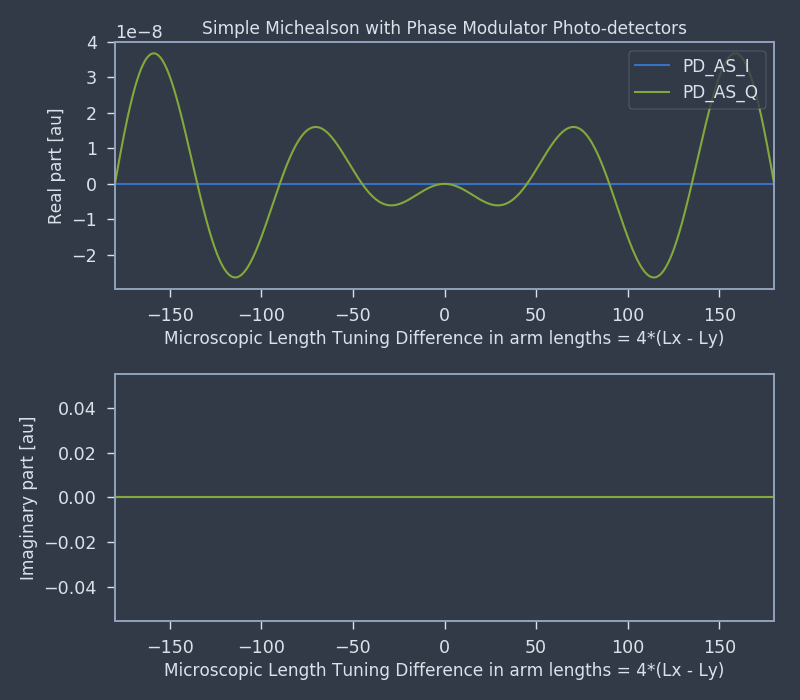

<IPython.core.display.Javascript object>


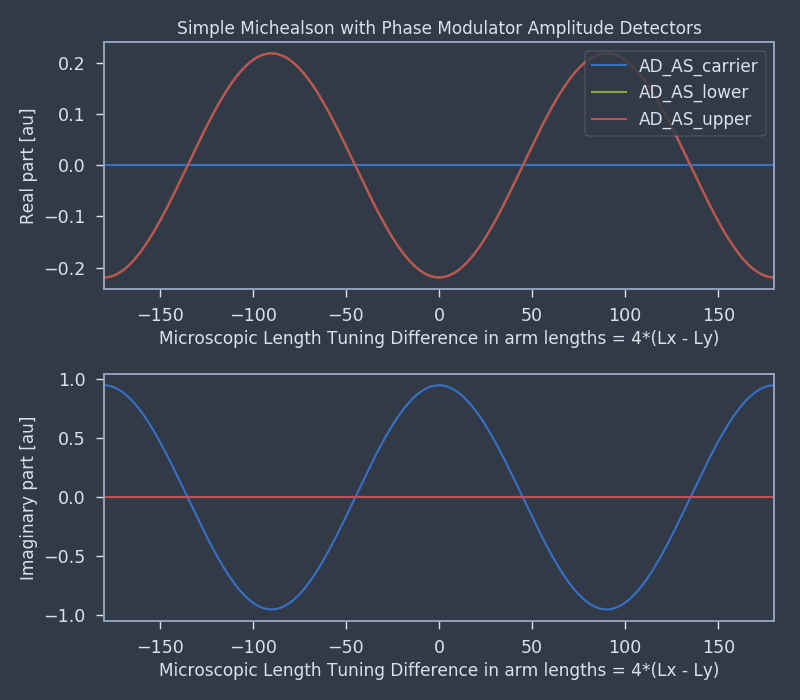

In [5]:
# Plots to show the amplitude of side bands and carrier, demodulated PD signals, 
# and carrier power vs variation of the microscopic differential length variation
# Note in these plots there is not variation of common mode length variation (Lx + Ly) 
kat1 = finesse.kat()
kat1.verbose = False
kat1.parse(basecode_pm) # Parsing the FINESSE-code
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -180 180 1000 #Mirror Y is varied -180 to 180 
put* ETMX phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat1.seom.L = seom_length 
#delta_L = 0
#kat1.sn.L = 1000.0 - delta_L
#kat1.se.L = 1000.0 + delta_L
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
out1.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Simple Michealson with Phase Modulator Photo-detectors",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out1.plot(detectors = ['AD_AS_carrier', 'AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Simple Michealson with Phase Modulator Amplitude Detectors",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

### Schnupp Asymmetry 
In the above example, operating point of is at macroscopic length difference to zero. Below are examples with macroscopic asymmetry with different lengths.

<IPython.core.display.Javascript object>


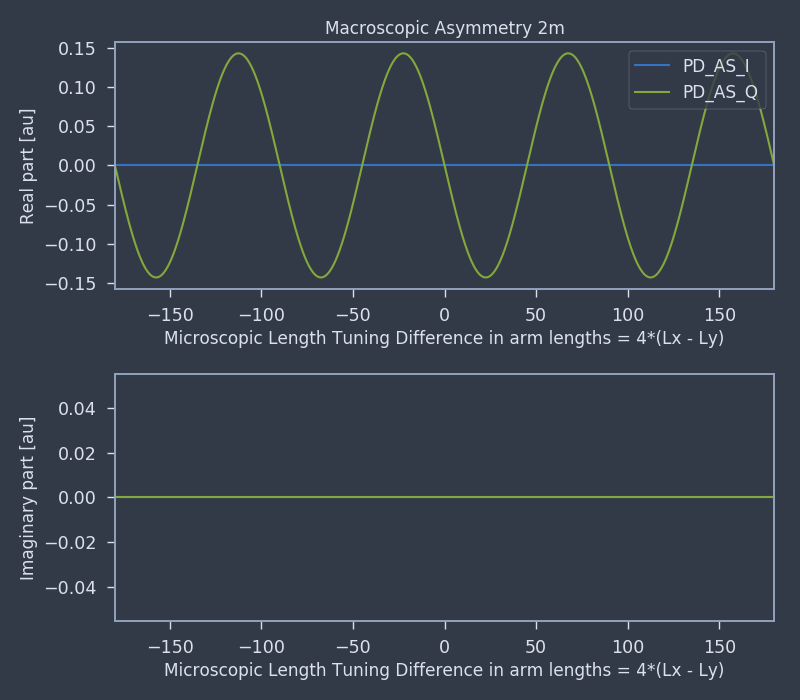

<IPython.core.display.Javascript object>


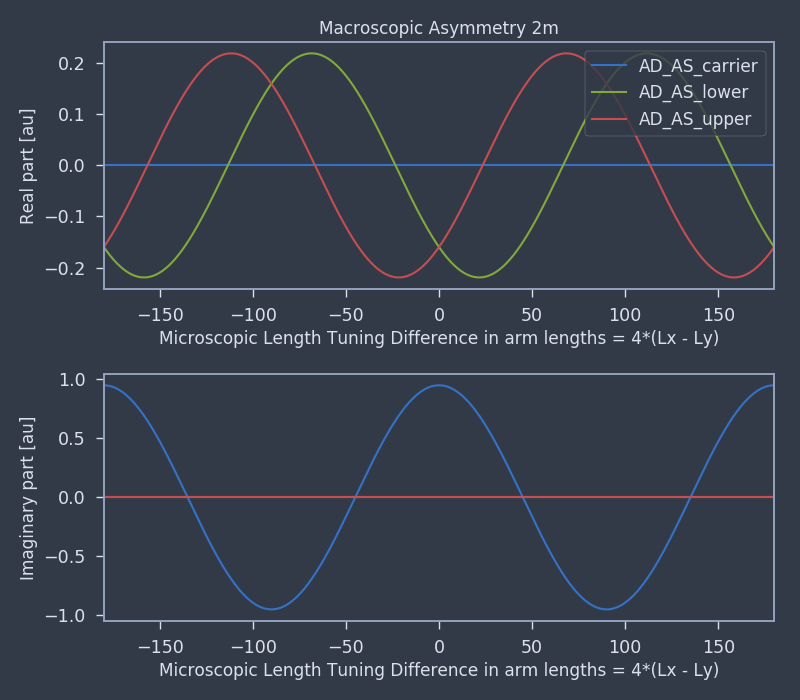

<IPython.core.display.Javascript object>


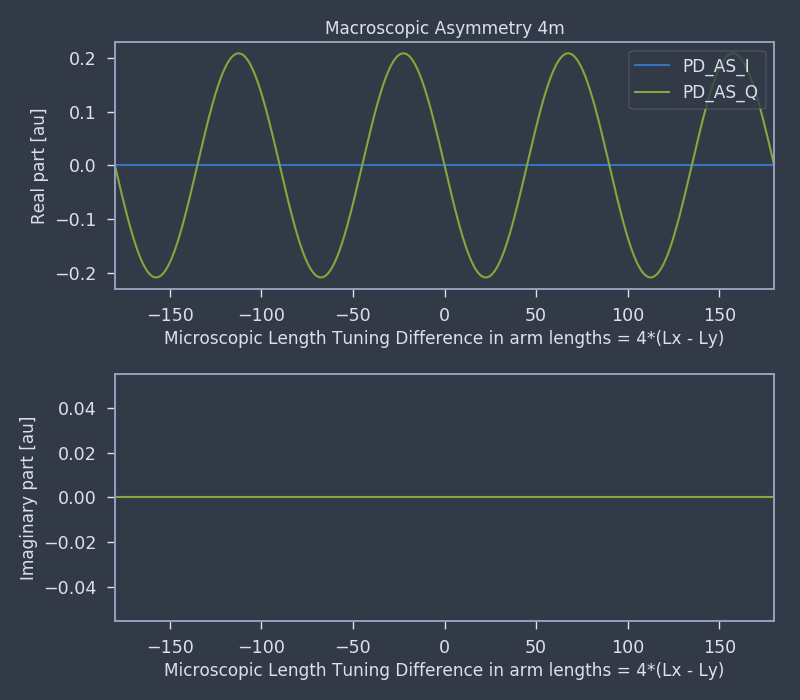

<IPython.core.display.Javascript object>


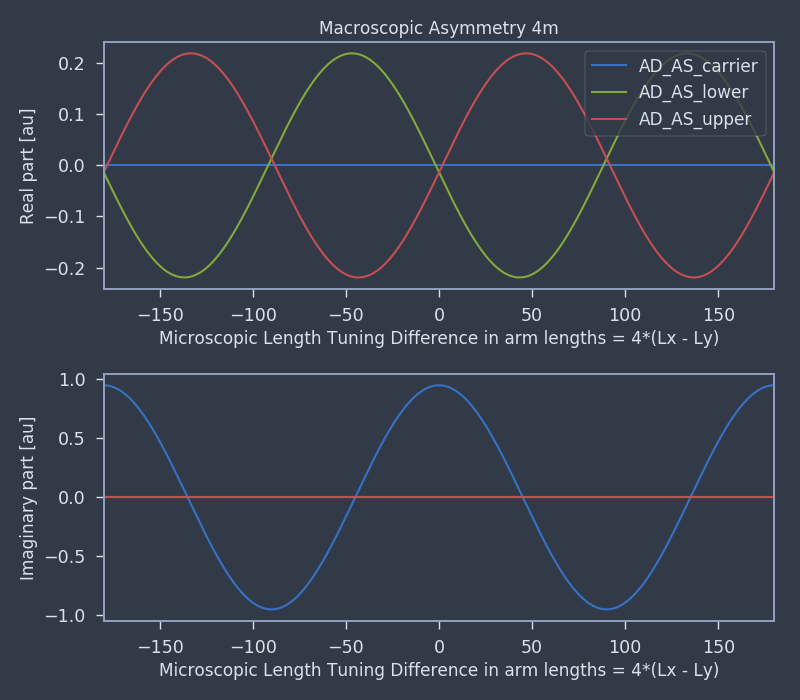

In [6]:
# Repeat the above with different macroscopic asymmetry settings.
kat2 = kat1.deepcopy()
delta_L = 2.0
kat2.sn.L = 1000.0 - delta_L
kat2.se.L = 1000.0 + delta_L
kat2.parse('yaxis re:im')
out2 = kat2.run()
out2.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Macroscopic Asymmetry 2m",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out2.plot(detectors = ['AD_AS_carrier', 'AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Macroscopic Asymmetry 2m",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
kat3 = kat1.deepcopy()
delta_L = 4.0
kat3.sn.L = 1000.0 - delta_L
kat3.se.L = 1000.0 + delta_L
kat3.parse('yaxis re:im')
out3 = kat3.run()
out3.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Macroscopic Asymmetry 4m",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out3.plot(detectors = ['AD_AS_carrier', 'AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Macroscopic Asymmetry 4m",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

In the above plots observe the sidebands amplitude at zero crossing of the carrier, that is dark fringe for the carrier. We also see the increase in PD_AS_Q (demodulated quadrature signal at asymmetric port), due to the asymmetry. Figure below, is the plot of PD_AS_Q signal at various asymmetries.  

<IPython.core.display.Javascript object>


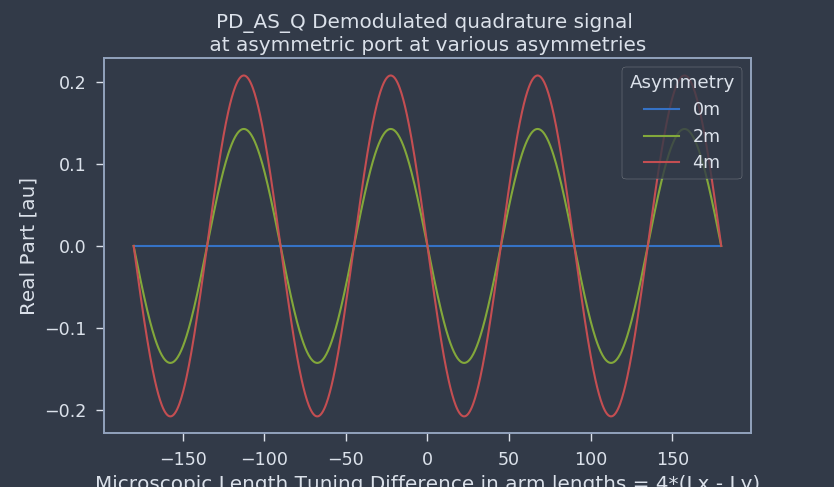

In [8]:
# Plot Showing PD_AS_Q at various arm length asymmetries. 
fig, ax = plt.subplots() 
ax.plot(out1.x, out1['PD_AS_Q'].real, label = "0m")  
ax.plot(out2.x, out2['PD_AS_Q'].real, label = "2m")  
ax.plot(out3.x, out3['PD_AS_Q'].real, label = "4m") 
ax.set_xlabel('Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)')
ax.set_ylabel('Real Part [au]')  
ax.set_title("PD_AS_Q Demodulated quadrature signal \n at asymmetric port at various asymmetries ")  
ax.legend(title = "Asymmetry", loc = 'upper right')  # Add a legend.
plt.show()

#### Optimize schnupp asymmetry for maximizing  quadrature signal at asymmetric port for simple michealson with phase modulator
Find asymmetry such that signal peak to peak is maximum.

In [9]:
# Optimize asymmetry for maximizing PD_AS_Q
kat4 = finesse.kat()
kat4.verbose = False
kat4.parse(basecode_pm)
kat4.seom.L = seom_length
detector_code = '''
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
'''
simulation_code = '''
xaxis ETMY phi lin 0 90 10000 #Mirror Y is varied -180 to 180 
put* ETMX phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat4.parse(detector_code)
kat4.parse(simulation_code)

def f(delta_L):
    kat4.sn.L = 1000.0 - delta_L
    kat4.se.L = 1000.0 + delta_L
    out4 = kat4.run()
    pk_to_pk = abs(max(out4['PD_AS_Q']) - 
                   min(out4['PD_AS_Q'])) #return peak to peak difference
    return -1.0 * pk_to_pk

from scipy import optimize
res = optimize.minimize_scalar(f,bounds = (0.0, 33))
schnupp_dL= res.x
print res
print "Asymmetry for Maximum PD_AS_Q = " + str(res.x)
print "Modulation Wavelength PD_AS_Q = " + str(seom_length)

     fun: -0.416757433553912
    nfev: 24
     nit: 19
 success: True
       x: 4.1637838825209785
Asymmetry for Maximum PD_AS_Q = 4.1637838825209785
Modulation Wavelength PD_AS_Q = 31.9266597778


<IPython.core.display.Javascript object>


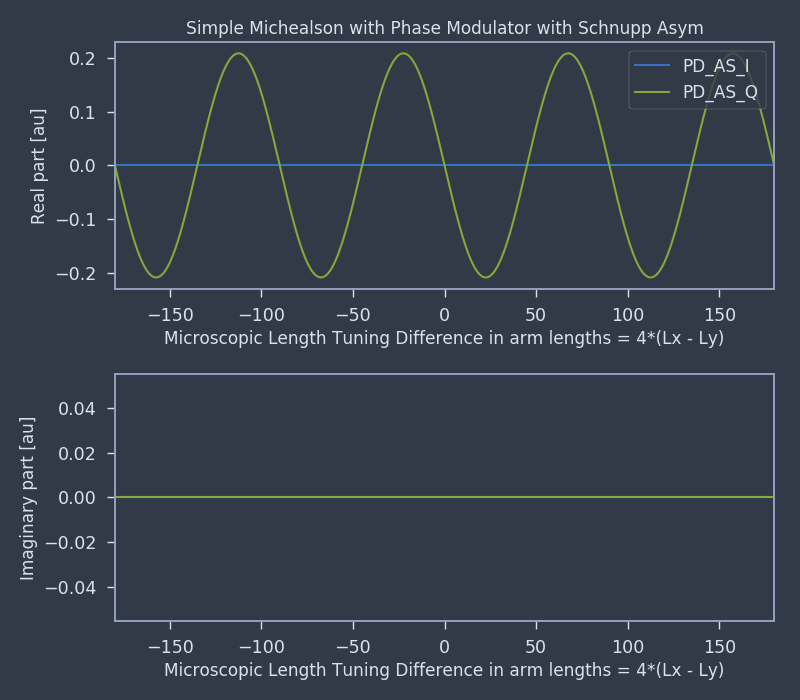

<IPython.core.display.Javascript object>


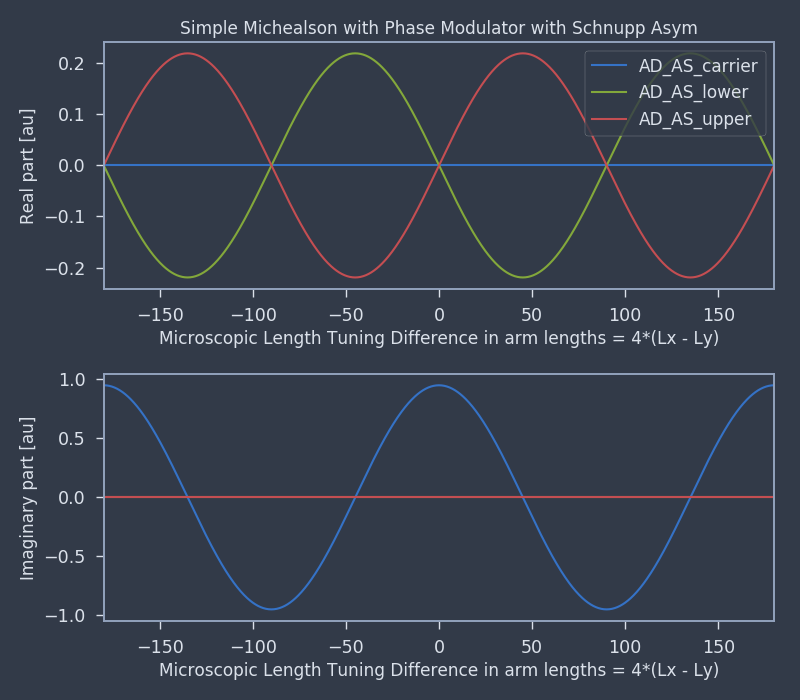

In [10]:
# plot the results with schnupp asymmetry
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -180 180 1000 #Mirror Y is varied -180 to 180 
put* ETMX phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat4.seom.L = seom_length 

delta_L = schnupp_dL
kat4.sn.L = 1000.0 - delta_L
kat4.se.L = 1000.0 + delta_L
kat4.parse(detector_code);
kat4.parse(simulation_code);
out4 = kat4.run()
out4.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Simple Michealson with Phase Modulator with Schnupp Asym",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out4.plot(detectors = ['AD_AS_carrier', 'AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Simple Michealson with Phase Modulator with Schnupp Asym",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

### Power recylced Michealson Interferometer

In [11]:
#Place the power recycling mirror such that recycling cavity is resonant with the sidebands.
#So, we need to optimized the space between PRM and BS such that recycling cavity resonant
#at the side band frequency
basekat_prm=finesse.kat() # initialising Finesse
basecode_prm = """
l laser 1 0 n0                     # Laser (Power = 1 W, wavelength offset = 0)
s sw 1 n0 nn1                      # Space (Length = 1 m)
m prm 0.8 0.2 0 nn1 nn4     # power recycling mirror R = 0.8, T = 0.2, phi = 0 
                            # lossless
s sprm 40 nn4 n1            # Space between prm and bs which will be optimized
                            # for resonant sidebands.
bs bs1 0.5 0.5 0 45 n1 n2 n3 n4   # Beam Splitter R = 0.5, T = 0.5, phi = 0, 
                                  # AoI = 45 
s sn 1000 n2 n5                   # Space BS and Mirror Y (Length Ly = 1000m)
m1 ETMY 5e-06 3.75e-05 0 n5 dump  # Mirror Y (R ~ 1)
s se 1000 n3 n6                   # Space BS and Mirror X (Length Lx = 1000m)
m1 ETMX 5e-06 3.75e-05 90 n6 dump # Mirror X (R ~ 1)
"""
basekat_prm.parse(basecode_prm)

<IPython.core.display.Javascript object>


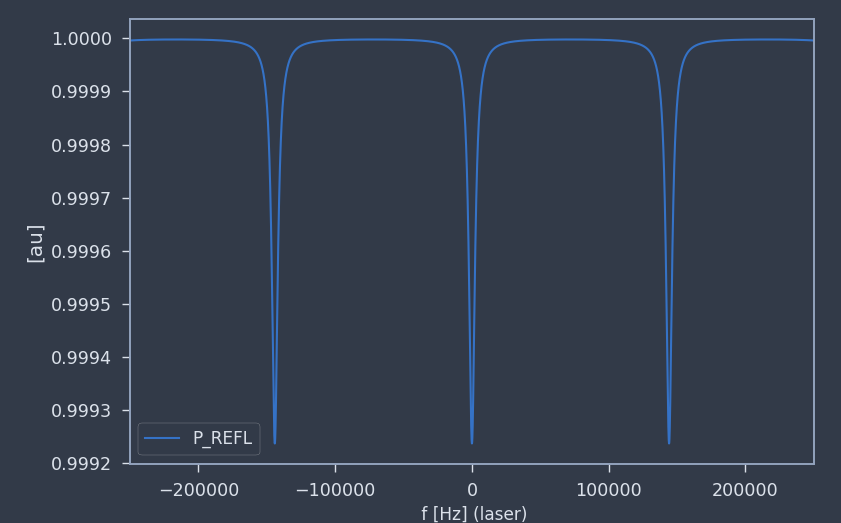

Resonant Frequency 0: -144150.0
Resonant Frequency 1: 0.0
Resonant Frequency 2: 144150.0
FSR = 144150.0


In [12]:
# Find the FSR of the cavity
kat1 = basekat_prm.deepcopy()
kat1.verbose = False
detector_code = '''
pd P_REFL nn1
'''
simulation_code = '''
xaxis laser f lin -250k 250k 10000
yaxis abs
'''
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
out1.plot()

# From the graph we can see that there are three resonant frequencies in the
# laser frequency scan
res_freq_list = []
for i in range(0,3):
    array_power = out1["P_REFL"][len(out1["P_REFL"])*i/3:len(out1["P_REFL"])*(i+1)/3]
    array_freq =  out1.x[len(out1["P_REFL"])*i/3:len(out1["P_REFL"])*(i+1)/3]  
    min_array_power = min(array_power)
    index_min = list(array_power).index(min_array_power)
    res_peak_freq = array_freq[index_min]
    print "Resonant Frequency " + str(i) + ": " + str(res_peak_freq)
    res_freq_list.append(res_peak_freq)
FSR_PRC = res_freq_list[-1] - res_freq_list[-2]
print "FSR = " +  str(FSR_PRC)

In [13]:
#Optimize distance between PRM and BS such that sidebands are resonant 
#in the power recycling cavity
kat2 = basekat_prm.deepcopy()
kat2.verbose = False
detector_code = '''
pd P_REFL nn1
'''
side_band_freq = 9.0e6
upper_limit = side_band_freq + FSR_PRC/2
lower_limit = side_band_freq - FSR_PRC/2
simulation_code_xaxis = ("xaxis laser f lin " + 
                         str(lower_limit) + " " + 
                         str(upper_limit) + " 10000 \n")
simulation_code_yaxis = "yaxis abs"
kat2.parse(detector_code)
kat2.parse(simulation_code_xaxis)
kat2.parse(simulation_code_yaxis)

# Function for optimizing  space between PRM and BS 'L' such that side bands resonate
# This function returns difference between resonant frequecny at given 'L' and side band
# frequency.
def f(L):
    kat2.sprm.L = L;
    out2 = kat2.run();
    index_res_peak = list(out2['P_REFL']).index(min(out2['P_REFL']))
    res_peak_freq = out2.x[index_res_peak]
    #out2.plot()
    #print side_band_freq - res_peak_freq 
    return side_band_freq - res_peak_freq 

# Find root such that difference in resonant freqency and sideband frequency is zero
from scipy import optimize
sol = optimize.root_scalar(f, bracket=[10, 20], method='brentq')
Lp = sol.root
print "Distance Between PRM and BS for sidebands to resonate = " + str(Lp)

Distance Between PRM and BS for sidebands to resonate = 15.963900443


In [14]:
# Plot above optimizing function f(L) vs  space between PRM and BS 'L'  
x = np.arange(0,40,0.10);
y = []
for i in x:
    y.append(f(i));

<IPython.core.display.Javascript object>


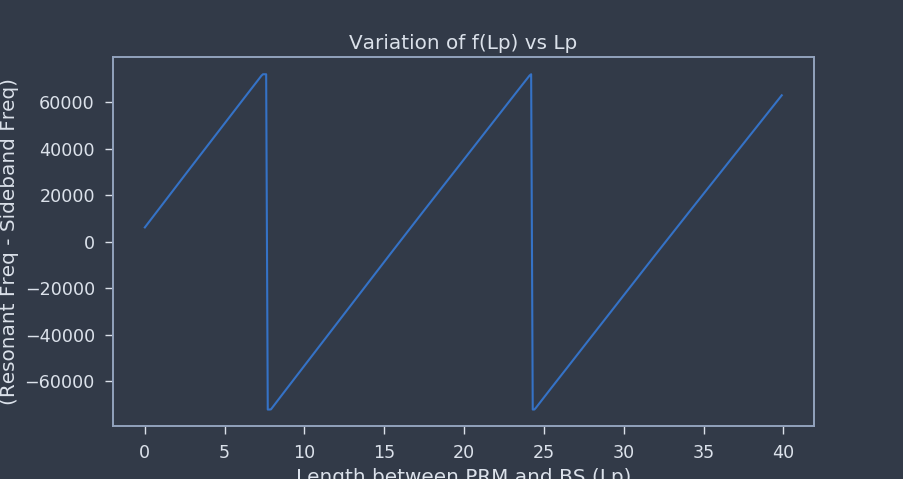

In [15]:
fig, ax = plt.subplots() 
ax.plot(x, y)  
ax.set_xlabel('Length between PRM and BS (Lp)')
ax.set_ylabel('(Resonant Freq - Sideband Freq)')  
ax.set_title("Variation of f(Lp) vs Lp")  
plt.show()

<IPython.core.display.Javascript object>


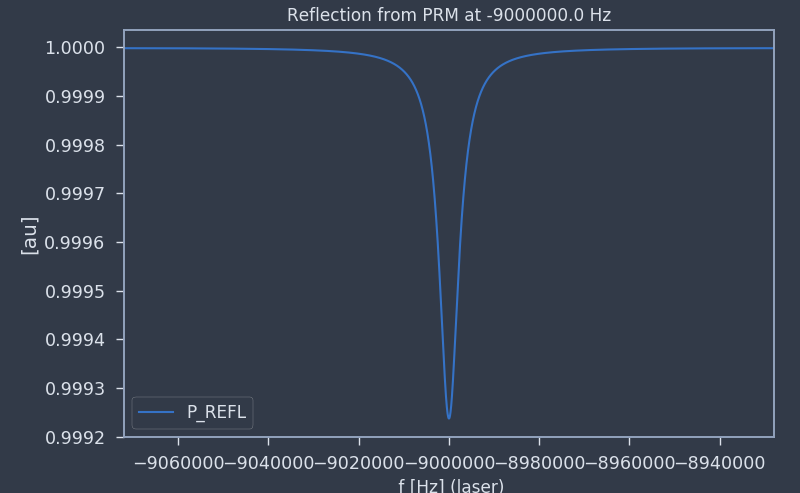

<IPython.core.display.Javascript object>


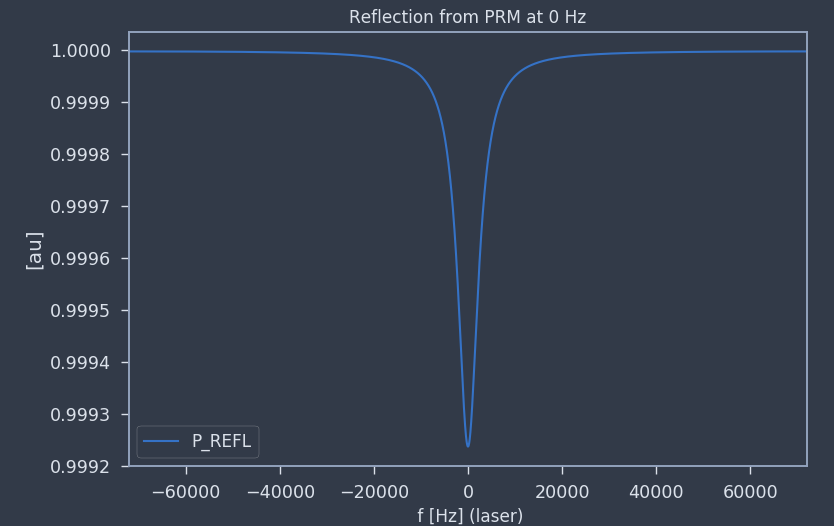

<IPython.core.display.Javascript object>


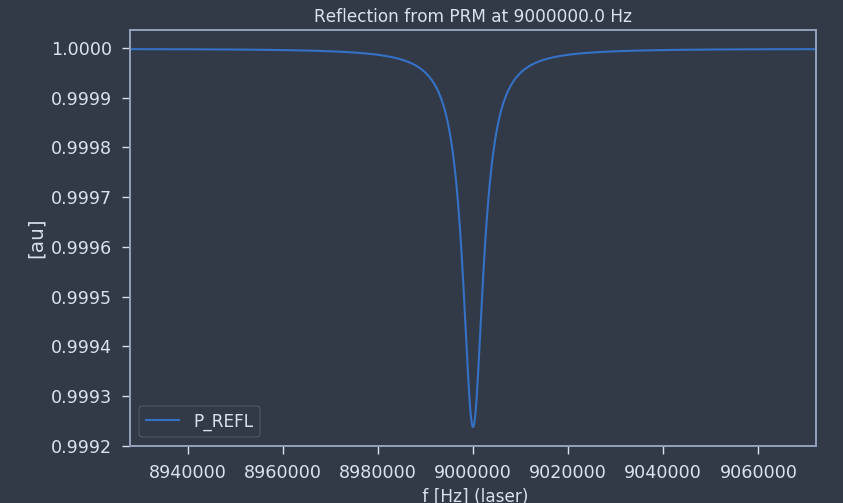

In [16]:
# Plot reflected power when freq offset is -9MHz, 0Hz, 9MHz to show that at above optimized
# length sideband and carrier are resonant
kat2 = basekat_prm.deepcopy()
kat2.verbose = False
detector_code = '''
pd P_REFL nn1
'''
kat2.sprm.L = Lp
freq_list = [-9e6, 0, 9e6]
for freq in freq_list:
    side_band_freq = freq
    upper_limit = side_band_freq + FSR_PRC/2
    lower_limit = side_band_freq - FSR_PRC/2
    simulation_code_xaxis = ("xaxis laser f lin " + 
                             str(lower_limit) + " " + 
                             str(upper_limit) + " 10000 \n")
    simulation_code_yaxis = "yaxis abs"
    kat2.parse(detector_code)
    kat2.parse(simulation_code_xaxis)
    kat2.parse(simulation_code_yaxis)
    out2 = kat2.run()
    out2.plot(title = "Reflection from PRM at " + str(freq) + " Hz")

<IPython.core.display.Javascript object>


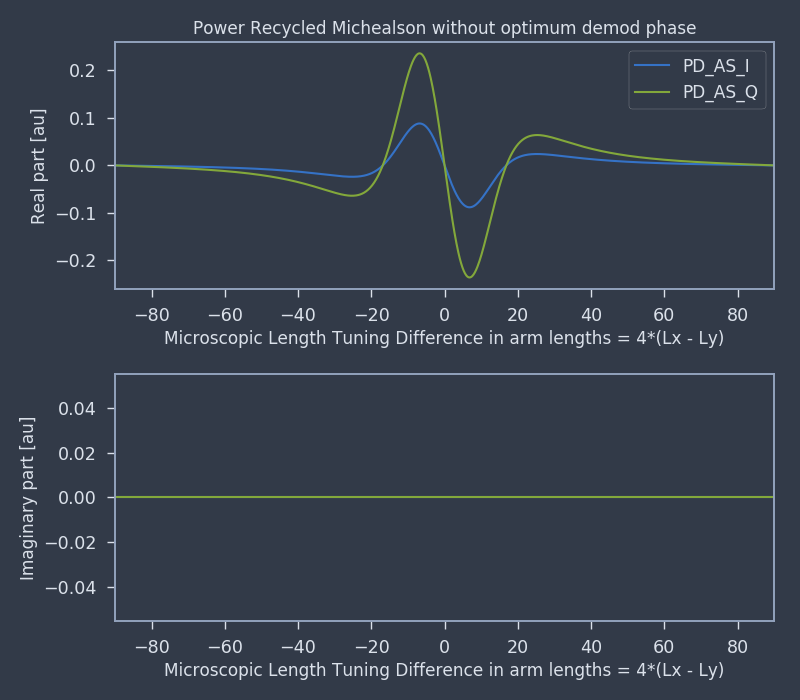

<IPython.core.display.Javascript object>


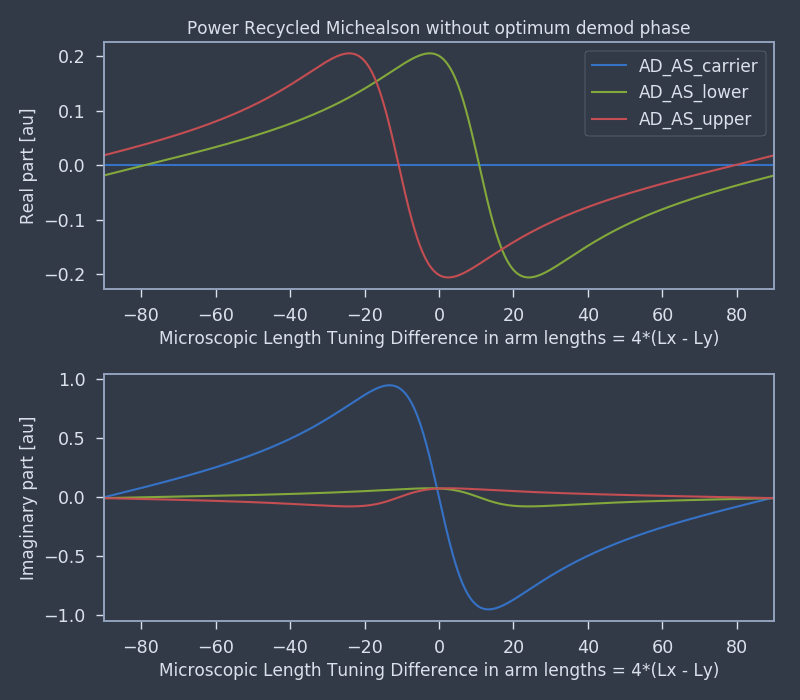

In [17]:
# Add eom to above setup and optimized the space between eom and PRM so that difference
# arm length signal is arrived only at quadrature of Asymmetric port (AS_Q)
#################################################################################
#Note: Mirror X (ETMX) inital phase phi = 90, which is dark for carrier.
#################################################################################
basekat_prm=finesse.kat() # initialising Finesse
basecode_prm = """
l laser 1 0 n0                     # Laser (Power = 1 W, wavelength offset = 0)
s sw 1 n0 nn1                      # Space (Length = 1 m)
mod eom1 9M 0.45 1 pm nn1 nn2       # Eom mod freq = 3MHz Lamda Mod ~ 33.33m 
s seom 33 nn2 nn3      # Space between the EOM and input to interferometer
                            # is adjust such that difference in path lengths is
                            # observed at Quadrature and common path length changes
                            # are observed as In Phase signals.
m prm 0.8 0.2 0 nn3 nn4     # power recycling mirror R = 0.8, T = 0.1, phi = 0 
                            # loss 0.1
s sprm 40 nn4 n1            # Space between prm and bs which will be optimized
                            # for resonant sidebands.
bs bs1 0.5 0.5 0 45 n1 n2 n3 n4     # Beam Splitter R = 0.5, T = 0.5, phi = 0, 
                                    # AoI = 45 
s sn 1000 n2 n5             # Space BS and Mirror Y (Length Ly = 1000m)
m1 ETMY 5e-06 3.75e-05 0 n5 dump         # Mirror Y (R = 1)
s se 1000 n3 n6             # Space BS and Mirror X (Length Lx = 1000m)
m1 ETMX 5e-06 3.75e-05 90 n6 dump         # Mirror X (R = 1)
"""
basekat_prm.parse(basecode_prm)
basekat_prm.sprm.L = Lp         # Set space between PRM and BS for sidebands to resonate.
kat1 = basekat_prm.deepcopy();
kat1.verbose = False
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -90 90 1000   #Mirror Y is varied -180 to 180 
put* ETMX phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat1.seom.L = 1.2            #Some random space between EOM and PRM input
delta_L = 1.0                #Some random asymmetry to see the signals
kat1.sn.L = 1000.0 - delta_L
kat1.se.L = 1000.0 + delta_L
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
out1.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Power Recycled Michealson without optimum demod phase",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out1.plot(detectors = ['AD_AS_carrier','AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Power Recycled Michealson without optimum demod phase",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

In [19]:
# Instead of tuning for appropriate phase of demodulator, space between EOM and BS
# is adjusted such that slope of in phase component due to differential variation of arm
# lengths is minimized. 
kat_Q_optimize = basekat_prm.deepcopy()
kat_Q_optimize.verbose = False;
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -90 90 1000 #Mirror Y is varied -180 to 180 
put* ETMX phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat_Q_optimize.parse(detector_code);
kat_Q_optimize.parse(simulation_code);
delta_L = 1.0   # Set some random asymmetry 
kat_Q_optimize.sn.L = 1000.0 - delta_L
kat_Q_optimize.se.L = 1000.0 + delta_L

# Function takes input for space between EOM and BS 
# and returns peak to peak value of the Inphase signal at
# asymmetric port.
def f(L):
    kat_Q_optimize.seom.L = L;
    res = kat_Q_optimize.run();
    #val = abs(min(res['PD_AS_I']) - max(res['PD_AS_I']))
    dy = np.diff(res['PD_AS_I'])
    dx = np.diff(res.x)
    slope = dy/dx
    val = slope[len(slope)/2]
    #print val
    return abs(val)

# Find the 'L' such that difference of imag part of side band is zero 
from scipy import optimize
res = optimize.minimize_scalar(f,bounds = (0.1, 33), 
                               method = 'bounded')
print res
print ("Space between EOM and PRM = " + str(res.x) + 
       " to get difference in arms lengths singal only at ASQ (Asymmetric Port Quadrature)")

# set distance between EOM and BS
seom_length_prm = res.x;
#f(1.2)

     fun: 9.919880365160807e-10
 message: 'Solution found.'
    nfev: 22
  status: 0
 success: True
       x: 15.957129338517195
Space between EOM and PRM = 15.957129338517195 to get difference in arms lengths singal only at ASQ (Asymmetric Port Quadrature)


<IPython.core.display.Javascript object>


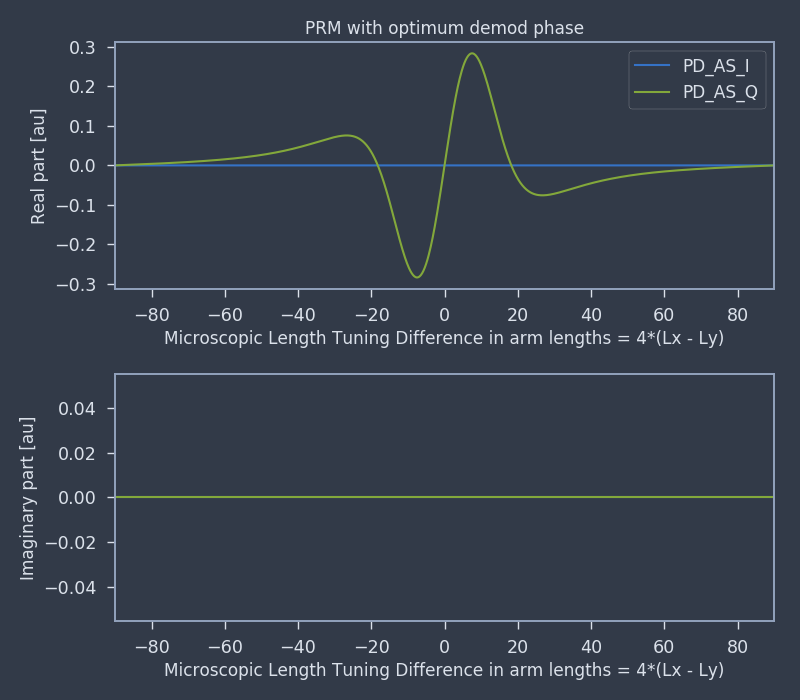

<IPython.core.display.Javascript object>


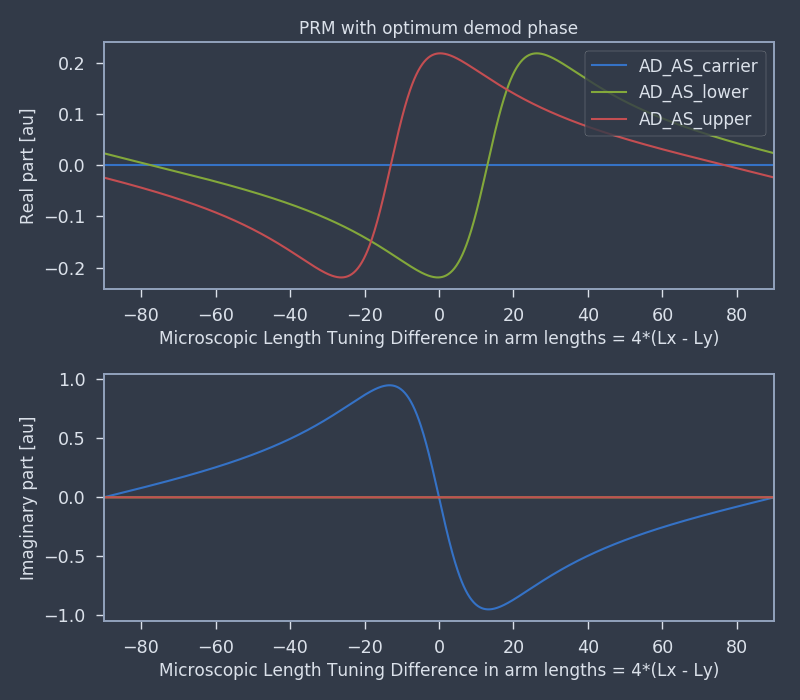

In [21]:
# In this plot at the optimized space between EOM and Assymetry port, Inphase signal
# at the asymmetry port is minimum
kat1 = basekat_prm.deepcopy();
kat1.verbose = False
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -90 90 1000 #Mirror Y is varied -180 to 180 
put* ETMX phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat1.seom.L = seom_length_prm
delta_L = 1.2
kat1.sn.L = 1000.0 - delta_L
kat1.se.L = 1000.0 + delta_L
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
out1.plot(detectors = ['PD_AS_I','PD_AS_Q'], loc = 'upper right',
         title = "PRM with optimum demod phase",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out1.plot(detectors = ['AD_AS_carrier','AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "PRM with optimum demod phase",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

In [43]:
# Optimize schnupp asymmetry for maximizing PD_AS_Q
basekat_prm.seom.L = seom_length_prm
kat4 = basekat_prm.deepcopy()
kat4.verbose = False
detector_code = '''
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
'''
simulation_code = '''
xaxis ETMY phi lin -90 90 10000    #Mirror Y is varied -90 to 90 
put* ETMX phi $mx1               #Mirror X is varied 90 to -90
yaxis re:im
'''
kat4.parse(detector_code)
kat4.parse(simulation_code)

def f(delta_L):
    kat4.sn.L = 1000.0 - delta_L
    kat4.se.L = 1000.0 + delta_L
    out4 = kat4.run()
    dy = np.diff(out4['PD_AS_Q'].real)
    dx = np.diff(out4.x)
    slope = dy/dx
    val = -1.0 * abs(slope[len(slope)/2])
    return val

from scipy import optimize
res = optimize.minimize_scalar(f,bounds = (0, 33))
schnupp_dL_prm= res.x
print res
print "Asymmetry for Maximum PD_AS_Q = " + str(res.x)
print "Modulation Wavelength PD_AS_Q = " + str(seom_length_prm)

     fun: -0.06160800602224687
    nfev: 22
     nit: 18
 success: True
       x: 1.2291295026326015
Asymmetry for Maximum PD_AS_Q = 1.2291295026326015
Modulation Wavelength PD_AS_Q = 15.957129338517195


<IPython.core.display.Javascript object>


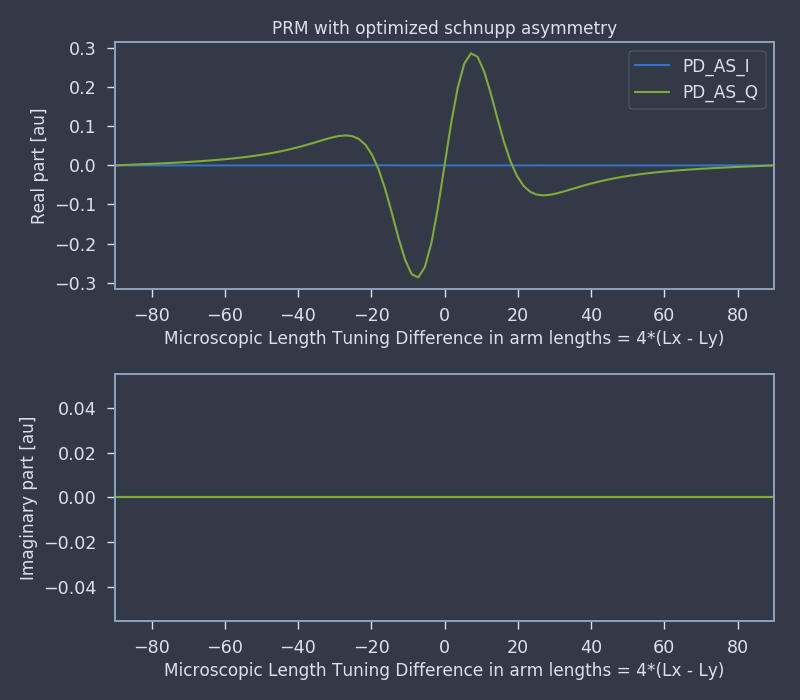

<IPython.core.display.Javascript object>


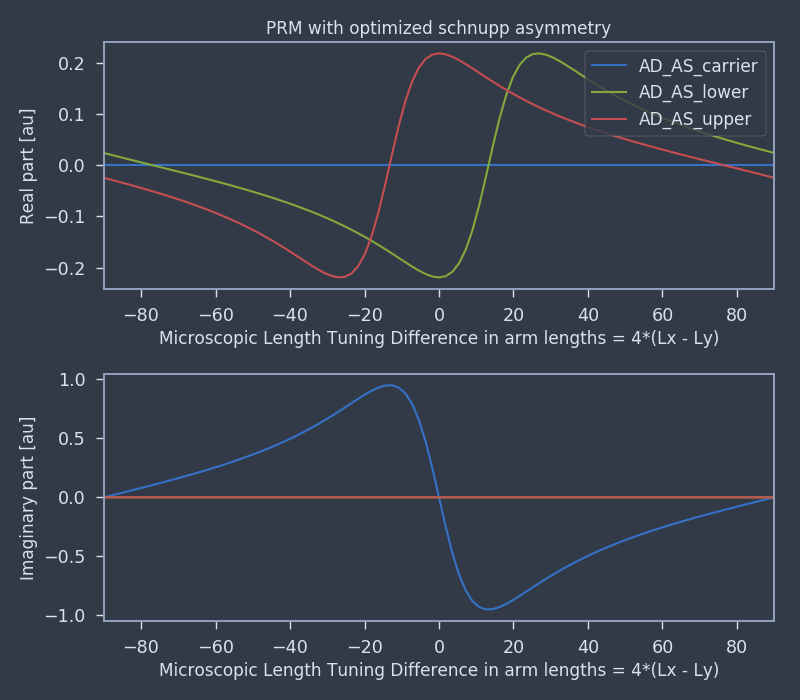

In [63]:
# In this plot PD_AS_I signal at optimized schnupp asymmetry for power recylced cavity
kat1 = basekat_prm.deepcopy();
kat1.verbose = False
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -90 90 100   #Mirror Y is varied -90 to 90 
put* ETMX phi $mx1               #Mirror X is varied  90 to -90
yaxis re:im
'''
delta_L = schnupp_dL_prm
kat1.sn.L = 1000.0 - delta_L
kat1.se.L = 1000.0 + delta_L
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
out1.plot(detectors = ['PD_AS_I','PD_AS_Q'], loc = 'upper right',
         title = "PRM with optimized schnupp asymmetry",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out1.plot(detectors = ['AD_AS_carrier','AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "PRM with optimized schnupp asymmetry",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

In [74]:
# 3D surface plot by X = R of PRM, Y = Schnupp Asymmetry, Z = Sensitivty of ASQ for 
# interferometer working at dark fringe for the carrier
PRM_R_arr = np.arange(0, 1, 0.1)
PRM_T_arr = 1.0 - PRM_R_arr
delta_L_arr = np.arange(0,16,0.2)
def func(PRM_R_arr, delta_L_arr):
    val = []
    for i in range(len(PRM_R_arr)):
        kat4.prm.R = PRM_R_arr[i];
        kat4.prm.T = 1.0 - PRM_R_arr[i]
        kat4.sn.L = 1000.0 - delta_L_arr[i]
        kat4.se.L = 1000.0 + delta_L_arr[i]
        out4 = kat4.run()
        dy = np.diff(out4['PD_AS_Q'].real)
        dx = np.diff(out4.x)
        slope = dy/dx
        val.append(abs(slope[len(slope)/2]))
        #print('\b\b ' + str(i), end = '')
    return np.array(val)
X = PRM_R_arr
Y = delta_L_arr
X, Y = np.meshgrid(X,Y)
zs = np.array(func(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

<IPython.core.display.Javascript object>


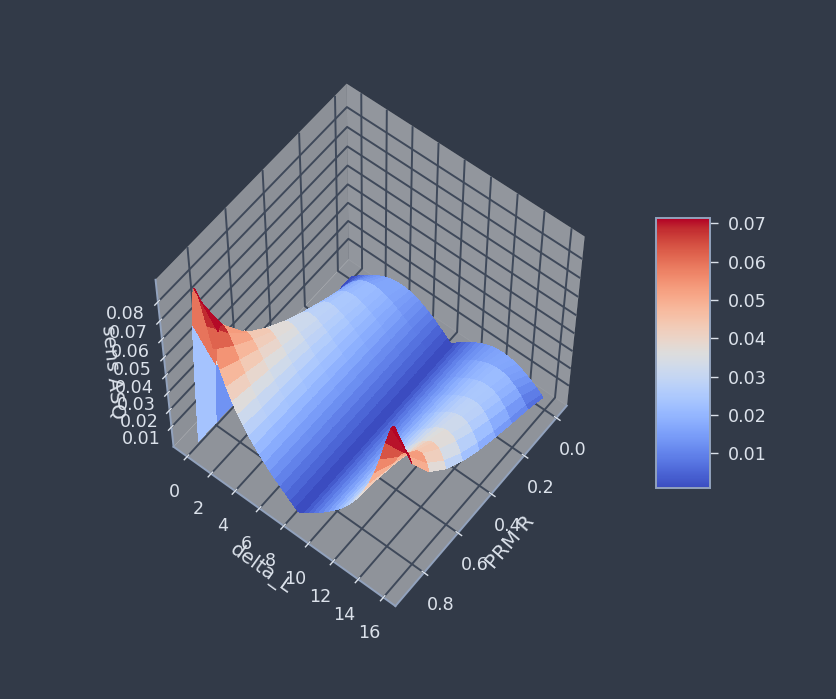

In [76]:
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('PRM R')
ax.set_ylabel('delta_L')
ax.set_zlabel('sens ASQ')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()